In [2]:
%load_ext autoreload
%autoreload 2

In [11]:
import importlib
from car_part import CarPartDataset, CarPartConfig, prepare_datasets, split_dataset_balanced
from pathlib import Path
import colorsys
import random
import numpy as np
import maskrcnn.model as modellib
from maskrcnn.model import log
from maskrcnn import visualize
import scipy.io as sio
import json

import matplotlib.pyplot as plt
import imageio
from pycocotools.coco import COCO

In [5]:
part_annotation_path = Path('./dataset/cogito_output_merged_solera.json')
images_path = Path('./dataset/')

In [6]:
json_file = open(part_annotation_path)
coco_data = json.load(json_file)
json_file.close()

In [35]:
anot=coco_data['annotations']

In [30]:
dataset_train = CarPartDataset()
id_to_category = dataset_train.load_dataset(part_annotation_path, images_path)
dataset_train.prepare()

num_img_not_it_annotations 10


In [33]:
#dicc = dataset_train.image_info
li = [a['category_id'] for a in anot[:20]]
id_to_category
#[id_to_category[l] for l in li]

{6: 'segment_back_side',
 7: 'segment_back_window',
 2: 'segment_back_bumper',
 16: 'segment_front_bumper',
 17: 'segment_front_door_left',
 18: 'segment_front_door_right',
 10: 'segment_door_pillar_left',
 11: 'segment_door_pillar_right',
 30: 'segment_rear_door_left',
 31: 'segment_rear_door_right',
 12: 'segment_door_sill_left',
 13: 'segment_door_sill_right',
 19: 'segment_front_door_window_left',
 20: 'segment_front_door_window_right',
 3: 'segment_back_fender_left',
 4: 'segment_back_fender_right',
 21: 'segment_front_fender_left',
 22: 'segment_front_fender_right',
 14: 'segment_fog_light_left',
 15: 'segment_fog_light_right',
 9: 'segment_car_handle_front',
 8: 'segment_car_handle_back',
 23: 'segment_front_headlight_left',
 24: 'segment_front_headlight_right',
 26: 'segment_front_side',
 27: 'segment_left_mirror',
 28: 'segment_left_right',
 5: 'segment_back_plate',
 25: 'segment_front_plate',
 29: 'segment_radiator_grill',
 32: 'segment_roofside',
 33: 'segment_taillight_left

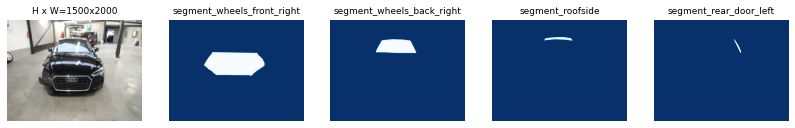

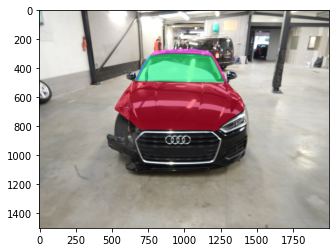

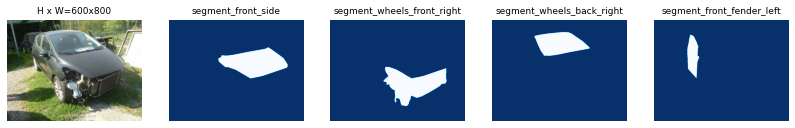

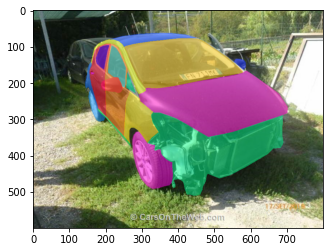

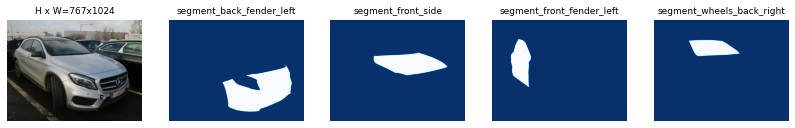

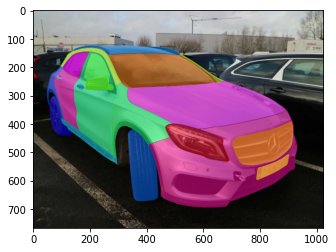

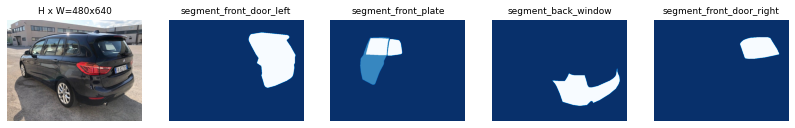

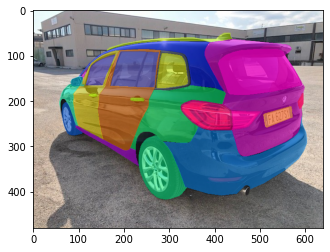

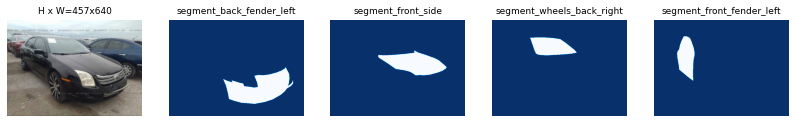

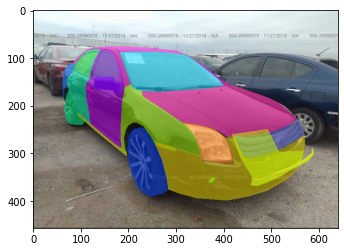

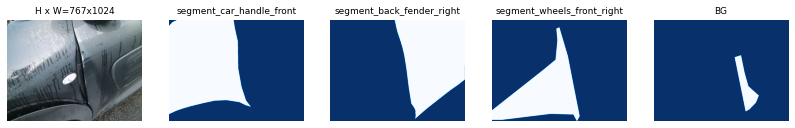

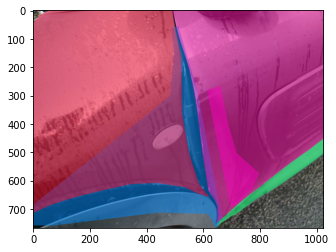

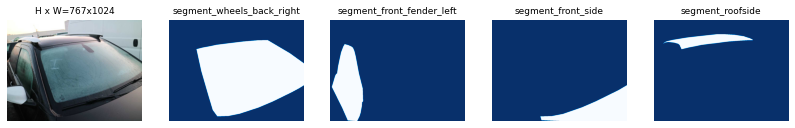

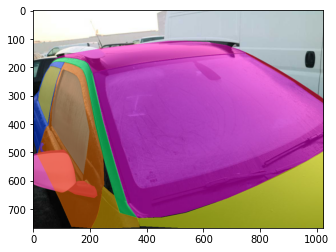

In [34]:
colors = visualize.generate_colormap(40, scaled=False)
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 7)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
    img_copy = image.copy()
    for l in range(mask.shape[-1]):
        img_copy = visualize.apply_mask(img_copy, mask[:,:,l], colors[l])
    plt.imshow(img_copy)

In [7]:
ds = COCO(part_annotation_path)
annotations_count = [
    (ds.cats[cat_id]['name'],len(images)) for cat_id, images in ds.catToImgs.items()
    ]

loading annotations into memory...
Done (t=3.69s)
creating index...
index created!


In [10]:
type(ds.getImgIds())

list

In [41]:
img_set = split_dataset_balanced(part_annotation_path)

loading annotations into memory...
Done (t=5.46s)
creating index...
index created!
0
4773
Distanza: 2798.85
4518
Distanza: 2797.30
1651
Distanza: 2794.02
1094
Distanza: 2790.63
2877
Distanza: 2788.68
4145
Distanza: 2785.25
3361
Distanza: 2783.64
2556
Distanza: 2779.69
1089
Distanza: 2776.61
2727
Distanza: 2775.60
2021
Distanza: 2772.83
3606
Distanza: 2768.80
2503
Distanza: 2766.31
1583
Distanza: 2765.17
4100
Distanza: 2761.59
3094
Distanza: 2759.23
4830
Distanza: 2755.68
846
Distanza: 2753.05
332
Distanza: 2748.11
4431
Distanza: 2742.95
2663
Distanza: 2741.28
2224
Distanza: 2738.99
2022
Distanza: 2737.93
2826
Distanza: 2735.90
1190
Distanza: 2732.54
1782
Distanza: 2730.78
515
Distanza: 2727.20
3705
Distanza: 2725.76
2105
Distanza: 2724.97
2598
Distanza: 2721.17
end remove
2247
Distanza: 2722.97
2053
Distanza: 2718.66
441
Distanza: 2714.91
723
Distanza: 2711.35
3224
Distanza: 2709.88
1884
Distanza: 2708.69
3378
Distanza: 2707.11
3602
Distanza: 2706.49
3799
Distanza: 2705.03
3991
Distanz

In [59]:
len(annotations_count)
damages_list = ['scratch', 'dent', 'severe-dent', 'substitution', 'severe_dent']
cats_count = list(filter(lambda x: x[0] not in damages_list, annotations_count))
cats_count = sorted(cats_count, key=lambda x: x[1], reverse=True)


In [60]:
cats_count

[('segment_rear_door_left', 4039),
 ('segment_rear_door_right', 4029),
 ('segment_car_handle_front', 3188),
 ('segment_roofside', 3178),
 ('segment_car_handle_back', 2779),
 ('segment_front_side', 2716),
 ('segment_door_pillar_right', 2486),
 ('segment_front_bumper', 2451),
 ('segment_door_pillar_left', 2411),
 ('segment_back_bumper', 2338),
 ('segment_windscreen', 2151),
 ('segment_left_right', 2007),
 ('segment_front_fender_right', 1998),
 ('segment_left_mirror', 1969),
 ('segment_radiator_grill', 1962),
 ('segment_front_door_right', 1955),
 ('segment_front_fender_left', 1935),
 ('segment_back_side', 1917),
 ('segment_front_door_left', 1917),
 ('segment_front_door_window_right', 1897),
 ('segment_front_door_window_left', 1888),
 ('segment_wheels_front_right', 1867),
 ('segment_wheels_back_right', 1852),
 ('segment_wheels_front_left', 1843),
 ('segment_wheels_back_left', 1836),
 ('segment_door_sill_right', 1833),
 ('segment_back_fender_right', 1829),
 ('segment_door_sill_left', 1827),

In [ ]:
c